In [1]:
"""
Fake News Classification with BERT and LIME for Interpretability
- Uses BERT model for text classification
- Implements LIME for model explanations
- Memory-optimized for Google Colab GPU
"""

'\nFake News Classification with BERT and LIME for Interpretability\n- Uses BERT model for text classification\n- Implements LIME for model explanations\n- Memory-optimized for Google Colab GPU\n'

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import roc_auc_score, classification_report, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import re
import time
from tqdm.notebook import tqdm

In [4]:
# Interpretability tool - LIME only (Couldn't get Captum to work)
!pip install lime
import lime
import lime.lime_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 18.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=bf14bac3fa79d2b1be2ed8d8f16735553db8de6c99d866ec025cd4b6e2c1d37b
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [5]:
# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

In [6]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: Tesla T4
Memory: 15.83 GB


In [7]:
# Dataset Loading
print("Please upload the four FakeNewsNet CSV files: gossipcop_fake.csv, gossipcop_real.csv, politifact_fake.csv, politifact_real.csv")
uploaded = files.upload()

Please upload the four FakeNewsNet CSV files: gossipcop_fake.csv, gossipcop_real.csv, politifact_fake.csv, politifact_real.csv


Saving gossipcop_fake.csv to gossipcop_fake.csv
Saving gossipcop_real.csv to gossipcop_real.csv
Saving politifact_fake.csv to politifact_fake.csv
Saving politifact_real.csv to politifact_real.csv


In [8]:
# Load and label the datasets
df_gossipcop_fake = pd.read_csv('gossipcop_fake.csv', sep=',', on_bad_lines='skip')
df_gossipcop_fake['label'] = 1  # Fake
df_gossipcop_real = pd.read_csv('gossipcop_real.csv', sep=',', on_bad_lines='skip')
df_gossipcop_real['label'] = 0  # Real
df_politifact_fake = pd.read_csv('politifact_fake.csv', sep=',', on_bad_lines='skip')
df_politifact_fake['label'] = 1  # Fake
df_politifact_real = pd.read_csv('politifact_real.csv', sep=',', on_bad_lines='skip')
df_politifact_real['label'] = 0  # Real

In [9]:
# Combine all datasets into one DataFrame
df = pd.concat([df_gossipcop_fake, df_gossipcop_real, df_politifact_fake, df_politifact_real], ignore_index=True)

In [10]:
# Preprocessing: Use 'title' column, remove NaN and short texts
df = df.dropna(subset=['title'])  # Drop rows with missing titles
df = df[df['title'].str.len() >= 10]  # Filter out titles shorter than 10 characters
df = df[['title', 'label']]  # Keep only relevant columns
print(f"Dataset size after filtering: {len(df)}")
print(f"Class distribution:\n{df['label'].value_counts()}")

Dataset size after filtering: 23196
Class distribution:
label
0    17441
1     5755
Name: count, dtype: int64


In [11]:
# Display a few examples
print("\nSample data:")
print(df.sample(5))


Sample data:
                                                   title  label
4291   Will Bindi Irwin Get Married to Boyfriend Chan...      1
14922  Bob Harper: Howard Stern Reached Out to Me Aft...      0
19868  'Guardians of the Galaxy Vol. 2' cast play Gue...      0
12669  'The X-Files': What Did Scully Whisper to Mulder?      0
12570  'Today': Ratings show replacing Matt Lauer wit...      0


In [12]:
# Data Preparation and Model Setup
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.raw_texts = [str(text) for text in texts]  # Store raw texts for interpretability

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long),
            'raw_text': self.raw_texts[idx]
        }

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [13]:
# Split dataset: 80% train, 10% validation, 10% test with stratification
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['title'].values, df['label'].values, test_size=0.2, stratify=df['label'], random_state=SEED
)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, stratify=temp_labels, random_state=SEED
)

print(f"Train size: {len(train_texts)}, Validation size: {len(val_texts)}, Test size: {len(test_texts)}")

Train size: 18556, Validation size: 2320, Test size: 2320


In [14]:
# Create datasets
train_dataset = NewsDataset(train_texts, train_labels, tokenizer)
val_dataset = NewsDataset(val_texts, val_labels, tokenizer)
test_dataset = NewsDataset(test_texts, test_labels, tokenizer)

In [15]:
# Create data loaders
batch_size = 8  # Reduced batch size to avoid OOM errors
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [16]:
# Load BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model = model.to(device)

# Use AdamW optimizer with weight decay
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
# Training function
def train_epoch(model, data_loader, optimizer, device, scheduler=None):
    model.train()
    total_loss = 0

    # Free up memory
    torch.cuda.empty_cache()

    progress_bar = tqdm(data_loader, desc="Training")
    for batch in progress_bar:
        # Zero gradients
        optimizer.zero_grad()

        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()
        if scheduler:
            scheduler.step()

        # Update statistics
        total_loss += loss.item()
        progress_bar.set_postfix({'loss': loss.item()})

        # Free up memory
        del input_ids, attention_mask, labels, outputs, loss
        torch.cuda.empty_cache()

    return total_loss / len(data_loader)

In [18]:
# Evaluation function
def evaluate(model, data_loader, device):
    model.eval()
    preds, true_labels, probs = [], [], []
    raw_texts = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            probabilities = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()

            preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            probs.extend(probabilities)

            # Store raw texts for interpretability
            if 'raw_text' in batch:
                raw_texts.extend(batch['raw_text'])

            # Free memory
            del input_ids, attention_mask, labels, outputs, logits
            torch.cuda.empty_cache()

    metrics = {
        'accuracy': accuracy_score(true_labels, preds),
        'f1': f1_score(true_labels, preds),
        'precision': precision_score(true_labels, preds),
        'recall': recall_score(true_labels, preds),
        'auc_roc': roc_auc_score(true_labels, probs)
    }

    return preds, true_labels, probs, raw_texts, metrics

In [19]:
# Train the model for 3 epochs
print("Starting training...")
num_epochs = 3
train_losses = []
val_metrics_history = []

for epoch in range(num_epochs):
    start_time = time.time()

    # Train for one epoch
    train_loss = train_epoch(model, train_loader, optimizer, device)
    train_losses.append(train_loss)

    # Evaluate on validation set
    val_preds, val_true, val_probs, val_texts, val_metrics = evaluate(model, val_loader, device)
    val_metrics_history.append(val_metrics)

    epoch_time = time.time() - start_time

    print(f"Epoch {epoch+1}/{num_epochs} - Time: {epoch_time:.2f}s")
    print(f"Training Loss: {train_loss:.4f}")
    print(f"Validation Metrics: Accuracy={val_metrics['accuracy']:.4f}, F1={val_metrics['f1']:.4f}, AUC={val_metrics['auc_roc']:.4f}")

Starting training...


Training:   0%|          | 0/2320 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/290 [00:00<?, ?it/s]

Epoch 1/3 - Time: 498.98s
Training Loss: 0.4077
Validation Metrics: Accuracy=0.8496, F1=0.6330, AUC=0.8963


Training:   0%|          | 0/2320 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/290 [00:00<?, ?it/s]

Epoch 2/3 - Time: 504.52s
Training Loss: 0.2739
Validation Metrics: Accuracy=0.8547, F1=0.7020, AUC=0.9040


Training:   0%|          | 0/2320 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/290 [00:00<?, ?it/s]

Epoch 3/3 - Time: 501.39s
Training Loss: 0.1699
Validation Metrics: Accuracy=0.8478, F1=0.6901, AUC=0.8820


In [20]:
# Step 4: Evaluate on validation set and generate confusion matrix
test_preds, test_true, test_probs, test_texts, test_metrics = evaluate(model, test_loader, device)

print("\nFinal Test Metrics:")
for metric_name, metric_value in test_metrics.items():
    print(f"{metric_name.capitalize()}: {metric_value:.4f}")

Evaluating:   0%|          | 0/290 [00:00<?, ?it/s]


Final Test Metrics:
Accuracy: 0.8513
F1: 0.6944
Precision: 0.7076
Recall: 0.6817
Auc_roc: 0.8879


In [21]:
# Classification Report
print("\nClassification Report:")
print(classification_report(test_true, test_preds, target_names=['Real', 'Fake']))


Classification Report:
              precision    recall  f1-score   support

        Real       0.90      0.91      0.90      1745
        Fake       0.71      0.68      0.69       575

    accuracy                           0.85      2320
   macro avg       0.80      0.79      0.80      2320
weighted avg       0.85      0.85      0.85      2320



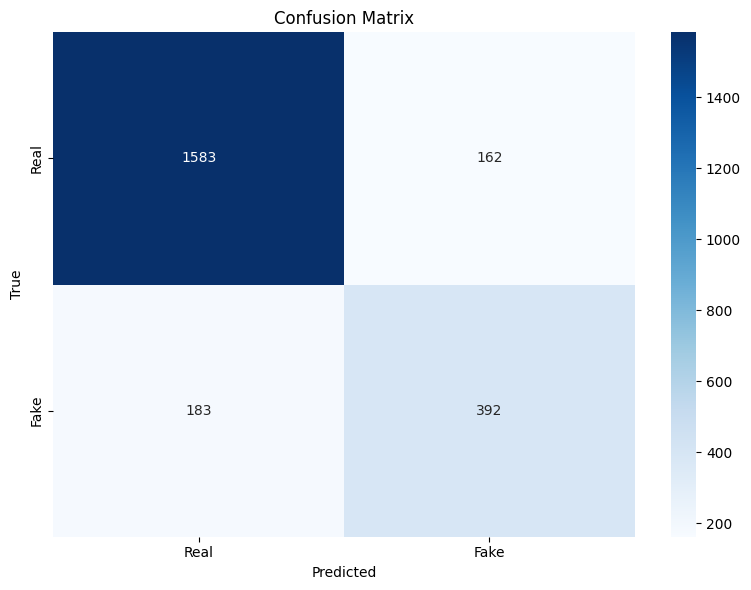

In [22]:
# Confusion matrix visualization
cm = confusion_matrix(test_true, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

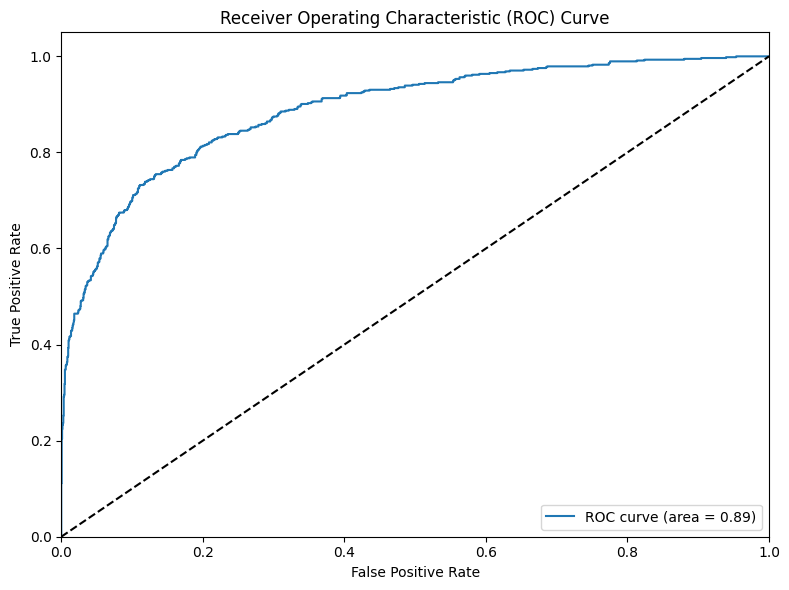

In [23]:
# ROC Curve
fpr, tpr, _ = roc_curve(test_true, test_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('roc_curve.png')
plt.show()

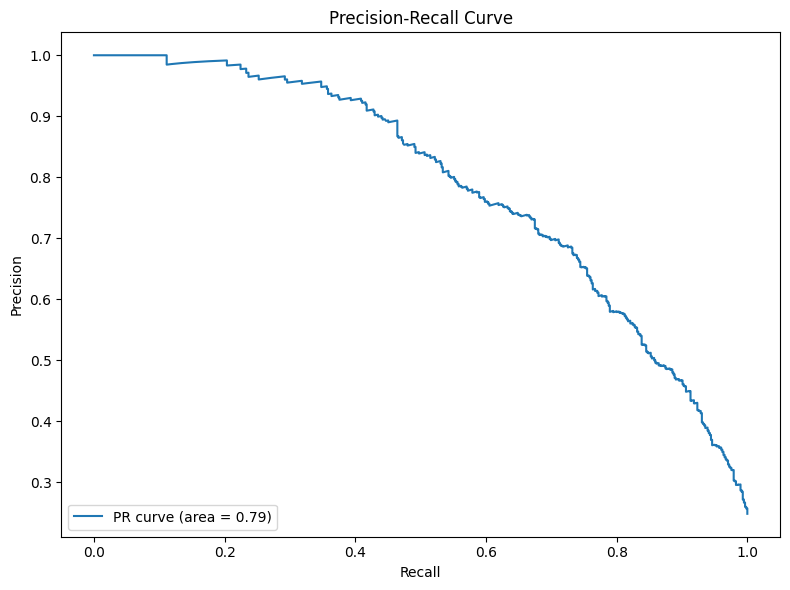

In [24]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(test_true, test_probs)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.tight_layout()
plt.savefig('pr_curve.png')
plt.show()

In [25]:
# Model Interpretability with Lime

def bert_pipeline_predict(texts):
    """
    Pipeline prediction function for LIME
    """
    model.eval()
    all_probs = []

    for text in texts:
        encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=128,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
            probs = torch.softmax(outputs.logits, dim=1).cpu().numpy()

        all_probs.append(probs[0])

        # Free memory
        del input_ids, attention_mask, outputs
        torch.cuda.empty_cache()

    return np.array(all_probs)

def analyze_with_lime(text, bert_pipeline_predict, class_names=['Real', 'Fake'], num_features=10):
    """
    Analyze a text sample with LIME
    """
    print(f"Text: {text}")

    # Create LIME explainer
    explainer = lime.lime_text.LimeTextExplainer(class_names=class_names)

    # Get explanation
    explanation = explainer.explain_instance(
        text,
        lambda x: bert_pipeline_predict(x),
        num_features=num_features,
        num_samples=500
    )

    # Get prediction
    probs = bert_pipeline_predict([text])[0]
    predicted_class = np.argmax(probs)

    print(f"Prediction: {class_names[predicted_class]} (Confidence: {probs[predicted_class]:.4f})")

    # Get feature weights
    weights = explanation.as_list()

    # Sort weights by absolute value for feature importance ranking
    weights.sort(key=lambda x: abs(x[1]), reverse=True)

    # Get top features and their weights
    features = [x[0] for x in weights[:num_features]]
    feature_weights = [x[1] for x in weights[:num_features]]

    # Create colors based on positive or negative contribution
    colors = ['green' if w > 0 else 'red' for w in feature_weights]

    # Create bar chart for feature importance ranking
    plt.figure(figsize=(10, 6))
    y_pos = range(len(features))
    plt.barh(y_pos, feature_weights, color=colors)
    plt.yticks(y_pos, features)
    plt.xlabel('Weight (Green = Contributes to Real, Red = Contributes to Fake)')
    plt.title(f'Top {num_features} Words Influencing Prediction: {class_names[predicted_class]}')
    plt.tight_layout()
    plt.savefig('lime_feature_importance.png')
    plt.show()

    # Create text highlighting visualization
    try:
        plt.figure(figsize=(10, 3))
        explanation.show_in_notebook(text=True, predict_proba=False)
        plt.title(f'Word Highlighting - Prediction: {class_names[predicted_class]}')
        plt.tight_layout()
        plt.savefig('lime_text_highlight.png')
        plt.show()
    except Exception as e:
        print(f"Could not generate text highlighting visualization: {str(e)}")

    # Print feature importance ranking table
    print("\nFeature Importance Ranking:")
    for i, (word, weight) in enumerate(weights[:num_features], 1):
        impact = "positive (Real)" if weight > 0 else "negative (Fake)"
        print(f"{i}. \"{word}\" - Impact: {impact}, Weight: {weight:.4f}")

    return explanation


===== MODEL INTERPRETABILITY DEMONSTRATIONS =====

--- LIME Analysis ---

Example 1 (True Class: Fake):
Text: Pregnant Khloe Kardashian enjoys baby shower with sisters and Kris
Prediction: Real (Confidence: 0.9891)


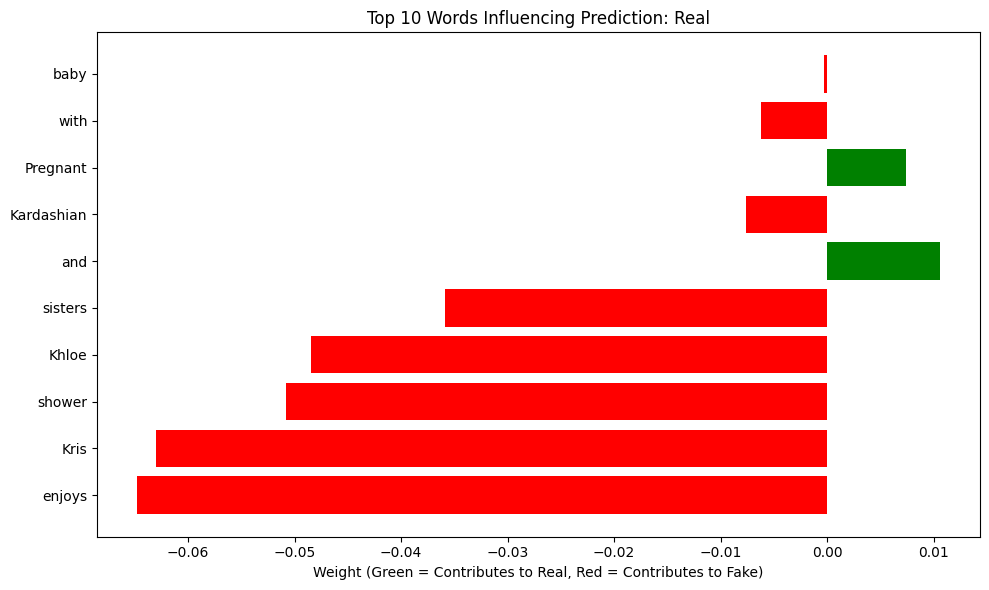

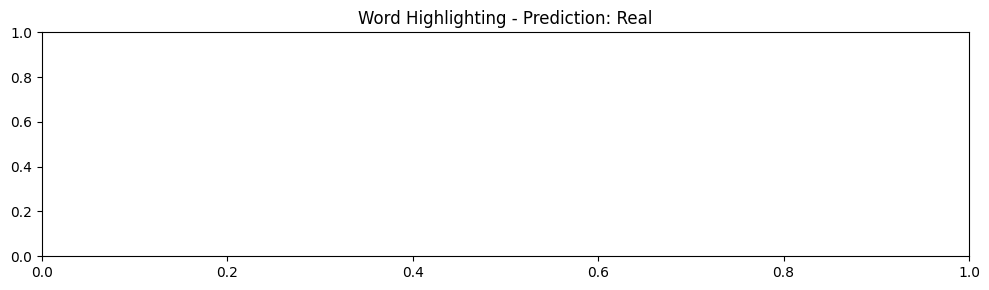


Feature Importance Ranking:
1. "enjoys" - Impact: negative (Fake), Weight: -0.0648
2. "Kris" - Impact: negative (Fake), Weight: -0.0630
3. "shower" - Impact: negative (Fake), Weight: -0.0508
4. "Khloe" - Impact: negative (Fake), Weight: -0.0485
5. "sisters" - Impact: negative (Fake), Weight: -0.0358
6. "and" - Impact: positive (Real), Weight: 0.0106
7. "Kardashian" - Impact: negative (Fake), Weight: -0.0076
8. "Pregnant" - Impact: positive (Real), Weight: 0.0075
9. "with" - Impact: negative (Fake), Weight: -0.0062
10. "baby" - Impact: negative (Fake), Weight: -0.0003

--------------------------------------------------

Example 2 (True Class: Fake):
Text: Camilla’s evil plot exposed
Prediction: Real (Confidence: 0.9740)


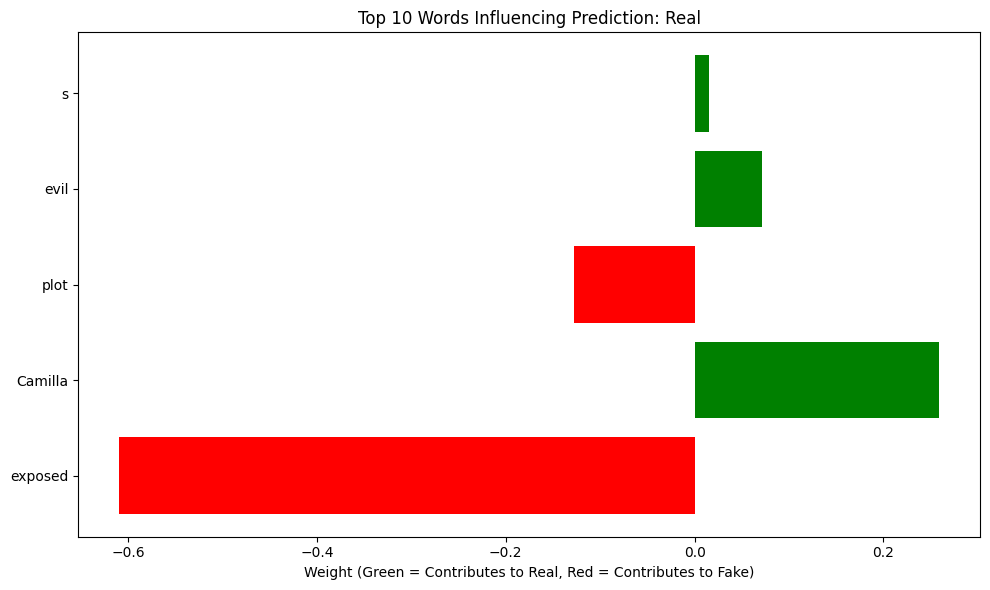

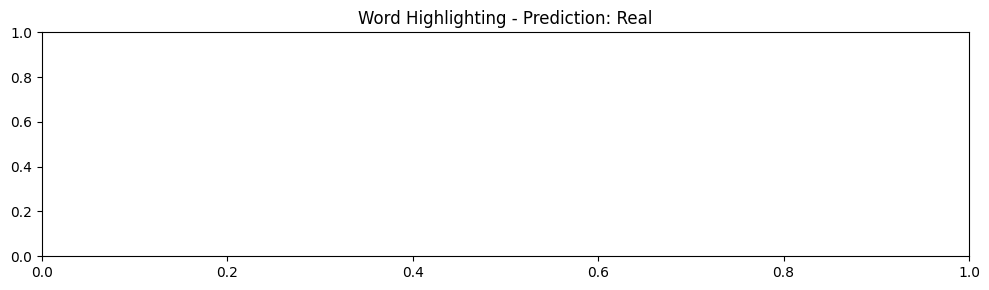


Feature Importance Ranking:
1. "exposed" - Impact: negative (Fake), Weight: -0.6095
2. "Camilla" - Impact: positive (Real), Weight: 0.2588
3. "plot" - Impact: negative (Fake), Weight: -0.1277
4. "evil" - Impact: positive (Real), Weight: 0.0713
5. "s" - Impact: positive (Real), Weight: 0.0151

--------------------------------------------------

Example 3 (True Class: Real):
Text: Orlando Bloom Stops Play Twice After Seeing Audience Member With iPad
Prediction: Real (Confidence: 0.7933)


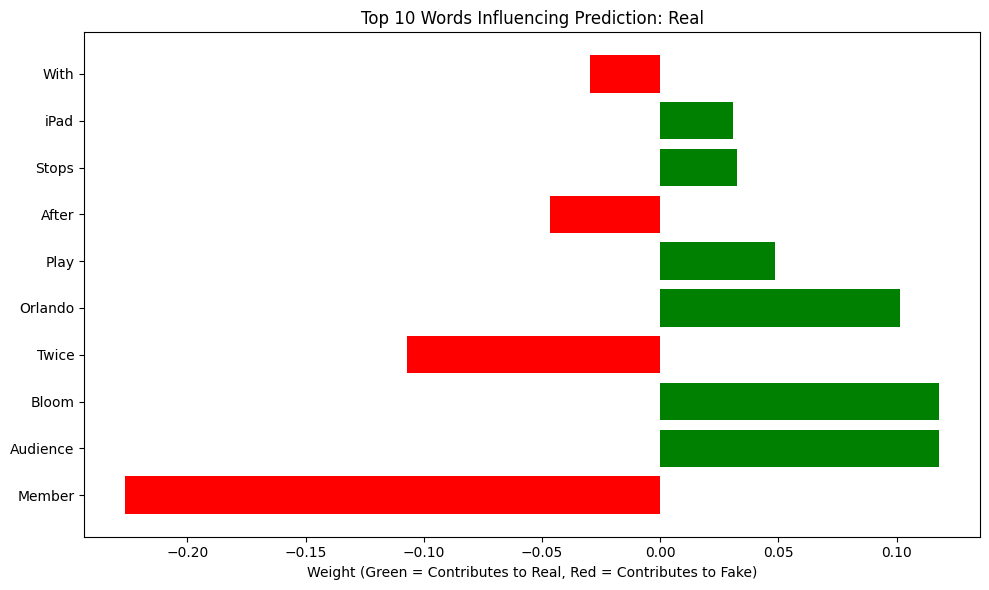

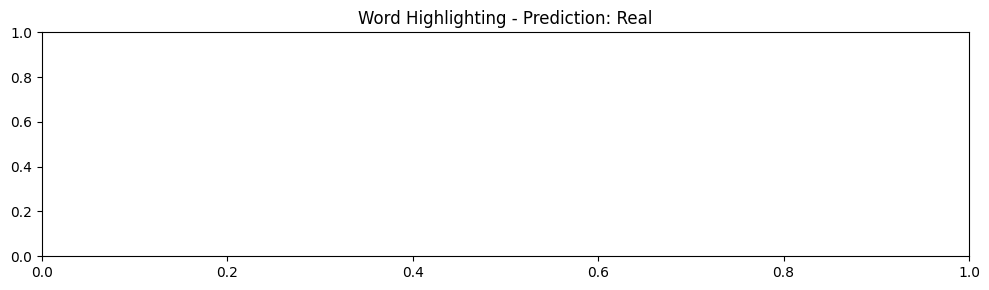


Feature Importance Ranking:
1. "Member" - Impact: negative (Fake), Weight: -0.2265
2. "Audience" - Impact: positive (Real), Weight: 0.1180
3. "Bloom" - Impact: positive (Real), Weight: 0.1180
4. "Twice" - Impact: negative (Fake), Weight: -0.1070
5. "Orlando" - Impact: positive (Real), Weight: 0.1014
6. "Play" - Impact: positive (Real), Weight: 0.0484
7. "After" - Impact: negative (Fake), Weight: -0.0465
8. "Stops" - Impact: positive (Real), Weight: 0.0327
9. "iPad" - Impact: positive (Real), Weight: 0.0307
10. "With" - Impact: negative (Fake), Weight: -0.0296

--------------------------------------------------

Example 4 (True Class: Real):
Text: Heidi Klum, 44, confirms split from Vito Schnabel, 31
Prediction: Real (Confidence: 0.6701)


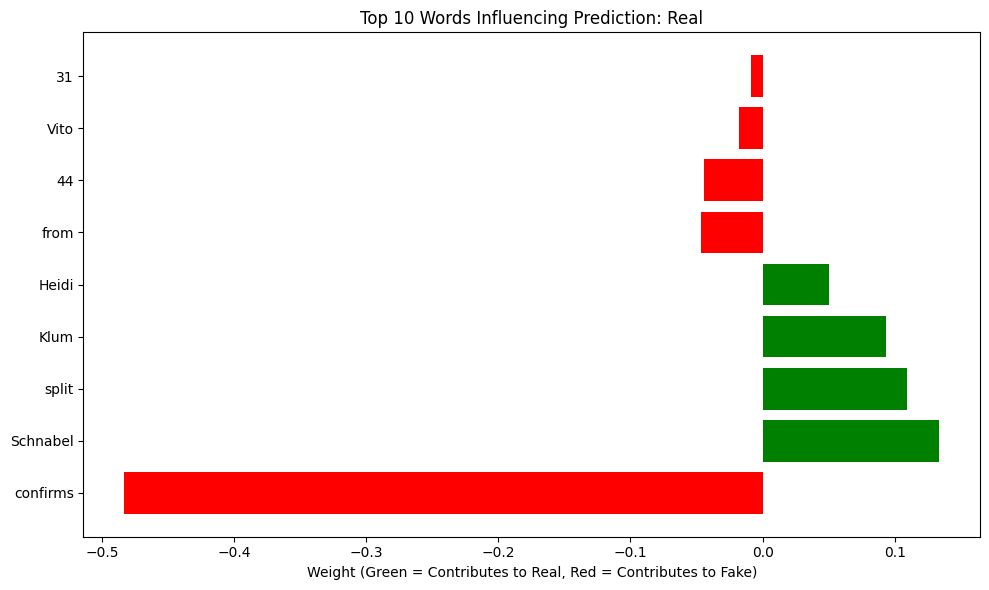

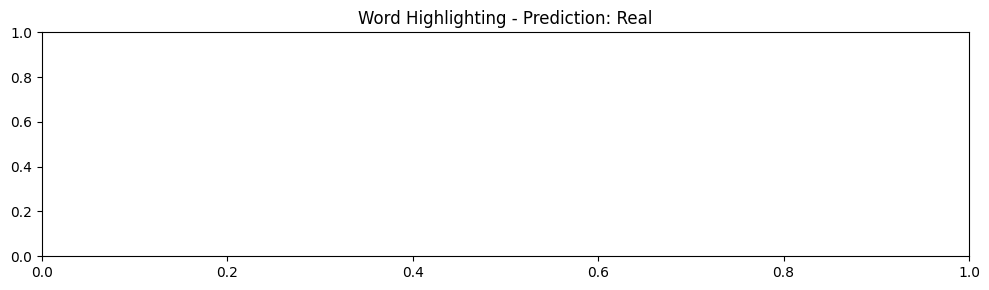


Feature Importance Ranking:
1. "confirms" - Impact: negative (Fake), Weight: -0.4832
2. "Schnabel" - Impact: positive (Real), Weight: 0.1337
3. "split" - Impact: positive (Real), Weight: 0.1093
4. "Klum" - Impact: positive (Real), Weight: 0.0935
5. "Heidi" - Impact: positive (Real), Weight: 0.0499
6. "from" - Impact: negative (Fake), Weight: -0.0463
7. "44" - Impact: negative (Fake), Weight: -0.0445
8. "Vito" - Impact: negative (Fake), Weight: -0.0178
9. "31" - Impact: negative (Fake), Weight: -0.0088

--------------------------------------------------


In [26]:
# Demonstrate Interpretability
print("\n===== MODEL INTERPRETABILITY DEMONSTRATIONS =====")

# Select examples for interpretation
def get_examples_for_interpretation(texts, labels, num_samples=2):
    """Get examples from each class for interpretation"""
    fake_indices = np.where(labels == 1)[0]
    real_indices = np.where(labels == 0)[0]

    # Get random samples from each class
    np.random.seed(SEED)
    fake_samples = np.random.choice(fake_indices, min(num_samples, len(fake_indices)), replace=False)
    real_samples = np.random.choice(real_indices, min(num_samples, len(real_indices)), replace=False)

    selected_indices = np.concatenate([fake_samples, real_samples])
    selected_texts = [texts[i] for i in selected_indices]
    selected_labels = [labels[i] for i in selected_indices]

    return selected_texts, selected_labels, selected_indices

# Get examples
selected_texts, selected_labels, selected_indices = get_examples_for_interpretation(test_texts, test_labels)

# LIME Analysis
print("\n--- LIME Analysis ---")
for i, (text, label) in enumerate(zip(selected_texts, selected_labels)):
    print(f"\nExample {i+1} (True Class: {'Fake' if label == 1 else 'Real'}):")
    lime_explanation = analyze_with_lime(
        text,
        bert_pipeline_predict,
        class_names=['Real', 'Fake'],
        num_features=10  # Show top 10 most important words
    )
    print("\n" + "-"*50)

In [27]:
# Save Model
model_path = "bert_misinfo_model_with_interpretability"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)
print(f"\nModel saved to {model_path}")


Model saved to bert_misinfo_model_with_interpretability


In [28]:
# Conclusion
print("\n===== MODEL EVALUATION SUMMARY =====")
print(f"Accuracy: {test_metrics['accuracy']:.4f}")
print(f"F1 Score: {test_metrics['f1']:.4f}")
print(f"AUC-ROC: {test_metrics['auc_roc']:.4f}")
print("\nModel interpretability implemented with LIME:")
print("- Feature importance ranking visualization")
print("- Word contribution highlighting")
print("- Text predictions with importance scores")
print("\nAll visualizations saved as PNG files")
print("\nKey benefits of LIME for fake news detection:")
print("1. Transparency: Understand why the model classifies news as real or fake")
print("2. Debugging: Identify potential biases or overfitting in the model")
print("3. Trust: Build confidence in the model's decisions through clear explanations")
print("4. Improvement: Refine the model based on insights from important features")


===== MODEL EVALUATION SUMMARY =====
Accuracy: 0.8513
F1 Score: 0.6944
AUC-ROC: 0.8879

Model interpretability implemented with LIME:
- Feature importance ranking visualization
- Word contribution highlighting
- Text predictions with importance scores

All visualizations saved as PNG files

Key benefits of LIME for fake news detection:
1. Transparency: Understand why the model classifies news as real or fake
2. Debugging: Identify potential biases or overfitting in the model
3. Trust: Build confidence in the model's decisions through clear explanations
4. Improvement: Refine the model based on insights from important features
